# Configuración para ejecución local y en Google Colab
Este notebook está diseñado para ejecutarse tanto en un entorno local como en Google Colab. A continuación, se incluyen las configuraciones necesarias para ambos entornos.

In [16]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path


# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn itertools tqdm
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/notebooks' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation.nc'
print(f"Buscando archivo en: {data_file}")

Entorno configurado. Usando ruta base: ..
Buscando archivo en: ../data/output/complete_dataset_with_features_with_clusters_elevation.nc


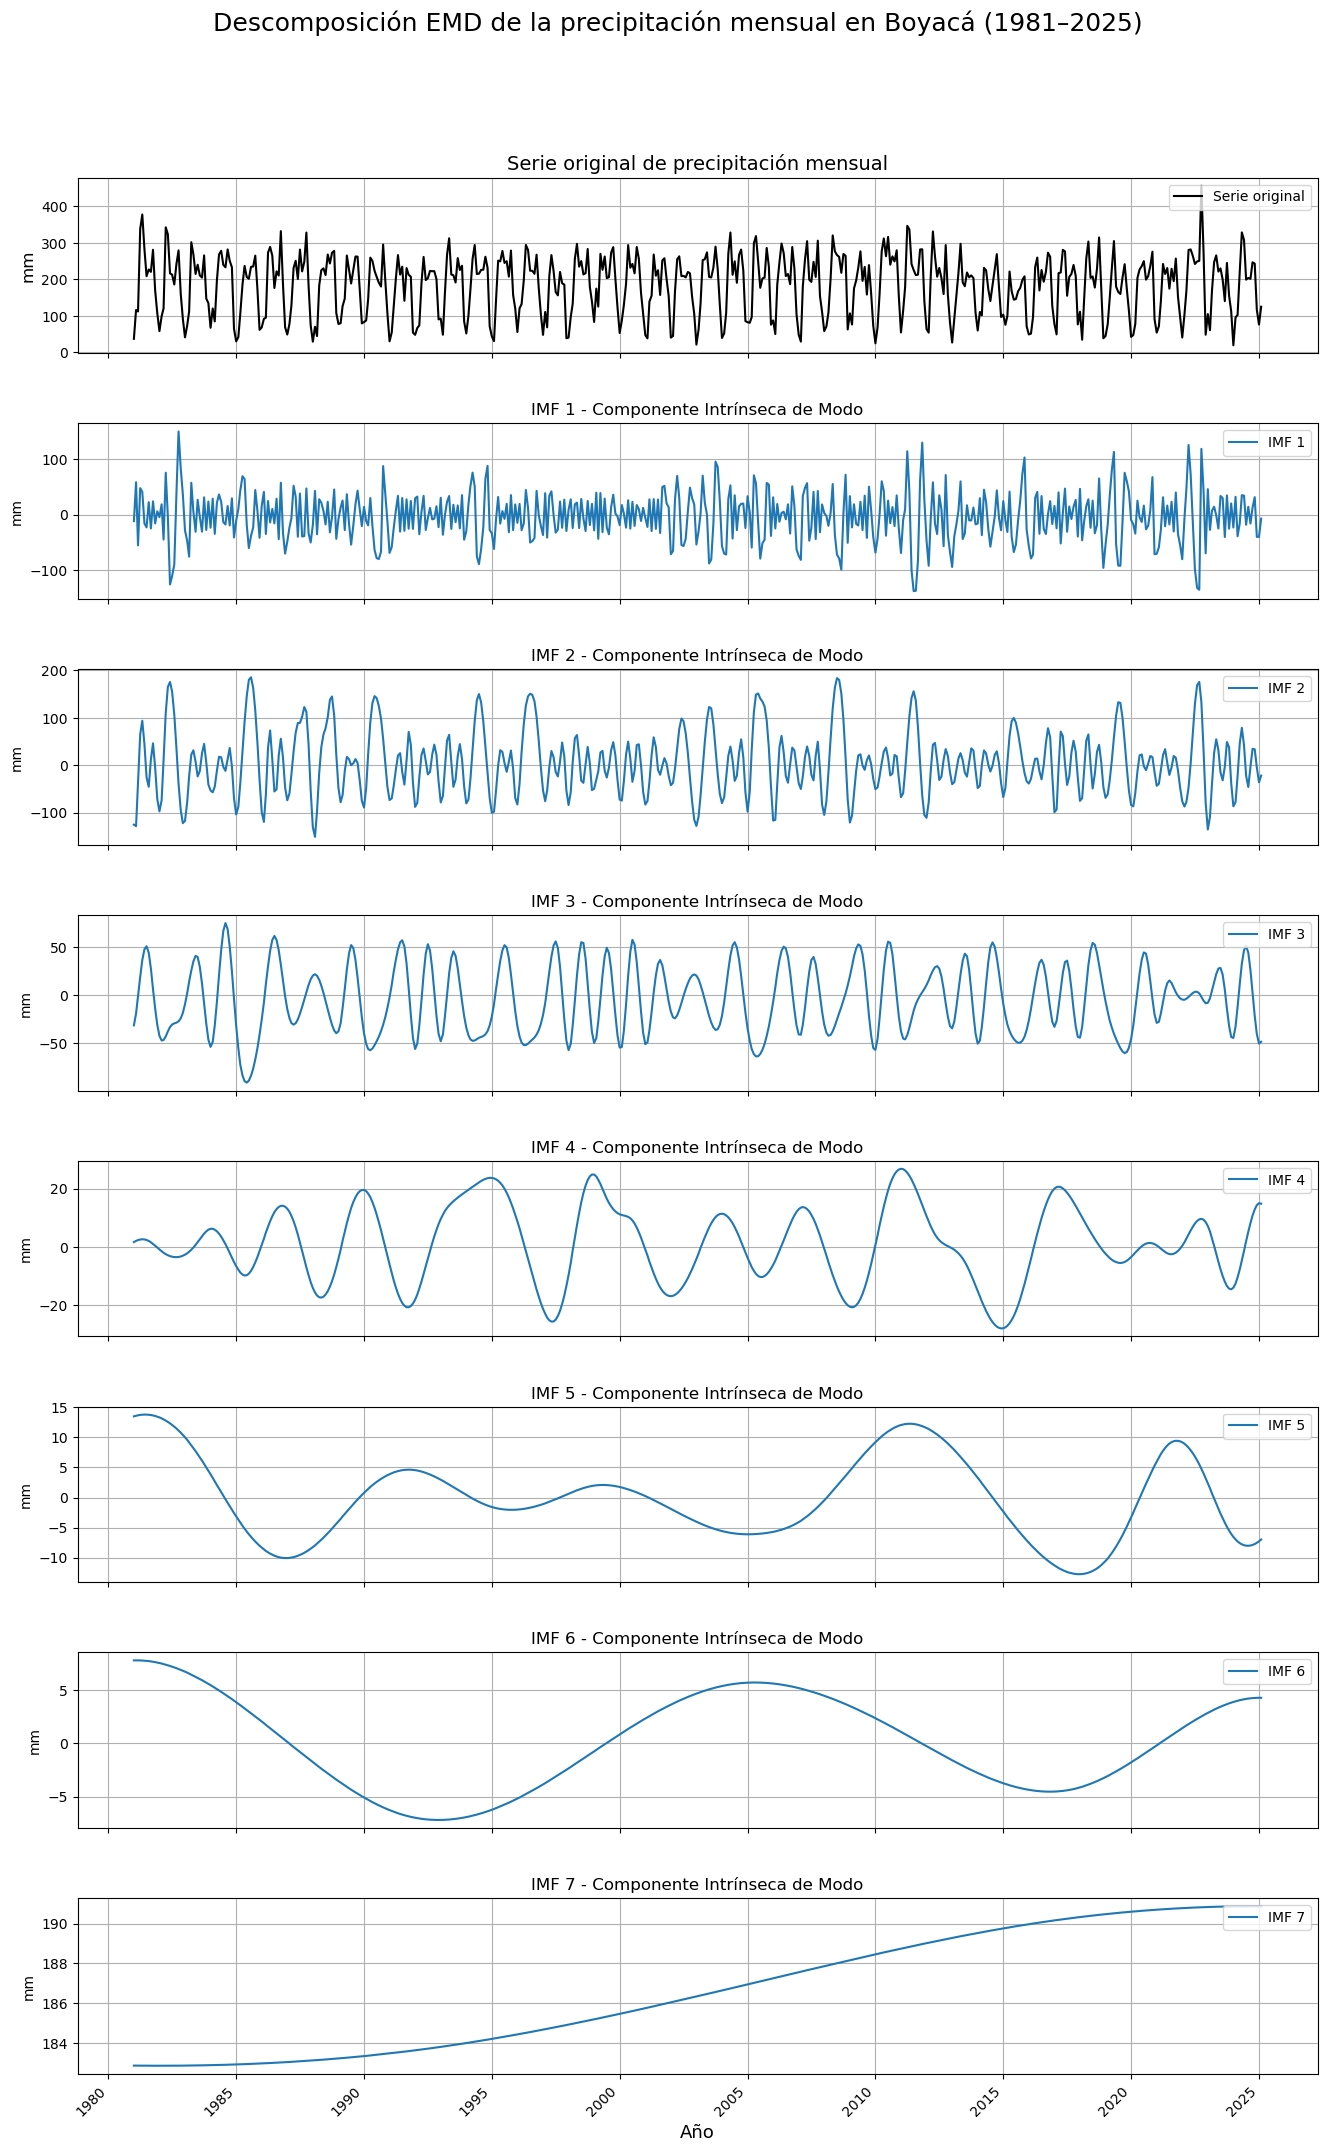

In [17]:
import xarray as xr
import pandas as pd
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# 📂 Cargar dataset
ds = xr.open_dataset(data_file)
precip = ds["total_precipitation"]
df = precip.to_dataframe().reset_index()
df["date"] = pd.to_datetime(df["time"])
df_monthly = df.groupby("date")["total_precipitation"].mean().interpolate()

# 🧠 Descomposición EMD
signal = df_monthly.values
emd = EMD()
imfs = emd.emd(signal)

# 🔢 Obtener rango de años
start_year = df_monthly.index.min().year
end_year = df_monthly.index.max().year

# 🎨 Graficar EMD (versión corregida de layout)
fig, axes = plt.subplots(
    imfs.shape[0] + 1, 1,
    figsize=(16, 3 * (imfs.shape[0] + 1)),
    sharex=True
)

# Ponemos el título general un poco más alto
fig.suptitle(
    f"Descomposición EMD de la precipitación mensual en Boyacá ({start_year}–{end_year})",
    fontsize=18,
    y=0.97      # subir el suptitle
)

# Ajustamos espacio vertical entre subplots y arriba
fig.subplots_adjust(
    top=0.90,  # reservamos el 10% superior para el suptitle
    hspace=0.4  # aumentamos el espacio entre filas
)

# --- resto idéntico ---
# Serie original
axes[0].plot(df_monthly.index, signal, color='black', label="Serie original")
axes[0].set_ylabel("mm", fontsize=12)
axes[0].set_title("Serie original de precipitación mensual", fontsize=14)
axes[0].legend(loc="upper right")
axes[0].grid(True)

# IMFs
for i in range(imfs.shape[0]):
    axes[i+1].plot(df_monthly.index, imfs[i], label=f"IMF {i+1}")
    axes[i+1].set_title(f"IMF {i+1} - Componente Intrínseca de Modo", fontsize=12)
    axes[i+1].set_ylabel("mm", fontsize=10)
    axes[i+1].grid(True)
    axes[i+1].legend(loc="upper right")

# Eje de fechas
axes[-1].xaxis.set_major_locator(mdates.YearLocator(base=5))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.xlabel("Año", fontsize=13)
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Suprimir warnings de pywt u otros

import os
import xarray as xr
import pandas as pd
import numpy as np
from PyEMD import CEEMDAN
from emd import sift  # TVF-EMD
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import acstools as tools
import contextlib
import io

# ----------------------------
# 1. Cargar dataset base
# ----------------------------
DATASET_PATH = data_file
ds = xr.open_dataset(DATASET_PATH)
precip = ds["total_precipitation"]

# ----------------------------
# 2. Estadísticas mensuales
# ----------------------------
time_diffs = np.diff(precip.time.values) / np.timedelta64(1, 'D')
monthly_sum = precip if np.median(time_diffs) > 2 else precip.resample(time='1M').sum(dim='time')

# ----------------------------
# 3. Funciones auxiliares
# ----------------------------
ceemdan = CEEMDAN()

def wavelet_energy(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return [np.sum(np.square(c)) for c in coeffs]

def compute_imfs_and_energy(ts, method='CEEMDAN'):
    # Capturar y descartar toda salida en pantalla
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        if method == 'TVF-EMD':
            imfs = sift.sift(ts, max_imfs=8)
        else:
            imfs = ceemdan.ceemdan(ts)
    energy_by_imf = [wavelet_energy(imf, level=4) for imf in imfs]
    return imfs, energy_by_imf, len(imfs)

def classify_frequency(row):
    if row['L1'] > max(row['L2'], row['L3'], row['L4'], row['Approx']):
        return 'Alta'
    elif row['L2'] > row['L3'] and row['L2'] > row['Approx']:
        return 'Media'
    else:
        return 'Baja'

# ----------------------------
# 4. Procesamiento por punto
# ----------------------------
latitudes = monthly_sum.latitude.values
longitudes = monthly_sum.longitude.values

energy_matrix = []

for lat in tqdm(latitudes, desc='Latitudes'):
    for lon in longitudes:
        ts = monthly_sum.sel(latitude=lat, longitude=lon).values
        if np.any(np.isnan(ts)):
            continue

        for method in ['CEEMDAN', 'TVF-EMD']:
            imfs, energy, n_modes = compute_imfs_and_energy(ts, method=method)
            for idx, e_levels in enumerate(energy):
                if len(e_levels) < 5:
                    continue
                energy_matrix.append({
                    'lat': float(lat), 'lon': float(lon),
                    'method': method, 'imf': idx + 1,
                    'n_imfs': n_modes,
                    'L1': e_levels[0], 'L2': e_levels[1],
                    'L3': e_levels[2], 'L4': e_levels[3],
                    'Approx': e_levels[4]
                })

# ----------------------------
# 5. Crear DataFrame
# ----------------------------
df_energy = pd.DataFrame(energy_matrix)
df_energy['frecuencia'] = df_energy.apply(classify_frequency, axis=1)

# ----------------------------
# 6. Visualización comparativa
# ----------------------------
sns.set(style='whitegrid')
for method in ['CEEMDAN', 'TVF-EMD']:
    df_m = df_energy[df_energy['method'] == method]
    for tipo in ['Alta', 'Media', 'Baja']:
        df_map = df_m[df_m['frecuencia'] == tipo] \
                  .groupby(['lat', 'lon']) \
                  .size() \
                  .reset_index(name='conteo')
        plt.figure(figsize=(8, 6))
        plt.scatter(df_map['lon'], df_map['lat'],
                    c=df_map['conteo'], cmap='viridis',
                    s=80, edgecolor='k')
        plt.colorbar(label=f'N° de IMFs {tipo}')
        plt.title(f"{method}: Distribución espacial de IMFs {tipo}")
        plt.xlabel("Longitud")
        plt.ylabel("Latitud")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ----------------------------
# 7. Exportar resultados
# ----------------------------
df_original = ds.to_dataframe().reset_index()
df_merge = pd.merge(
    df_energy,
    df_original,
    how='left',
    left_on=['lat', 'lon'],
    right_on=['latitude', 'longitude']
)
df_merge["imf"] = df_merge["imf"].astype(int)
ds_features = df_merge.set_index(["lat", "lon", "imf"]).to_xarray()
ds_combined = xr.merge([ds, ds_features])

nc_path = os.path.join(model_output_dir, "dataset_ceemdan_tvfemd_features.nc")
ds_combined.to_netcdf(nc_path)

tools.display_dataframe_to_user(
    name="CEEMDAN + TVF-EMD Features",
    dataframe=df_merge
)


Latitudes:   0%|          | 0/61 [00:00<?, ?it/s]